In [1]:
from pathlib import Path
import sys
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import matplotlib

In [2]:
here = Path('.').resolve()
benchmarks = (here / '..').resolve()
print(benchmarks)
sys.path.append(str(benchmarks))

plt.rcParams.update({
    'font.size': 8,
    'text.usetex': True,
    'text.latex.preamble': r'\usepackage{amsfonts}',
    "figure.figsize": (6,4),
    'figure.dpi':150
})

sns.set_theme()
sns.set(font_scale=1.3)
sns.set_style("whitegrid")

/scratch/ndeutsch/zunis/zunis/experiments/benchmarks


In [3]:
from utils.data_storage.dataframe2sql import read_pkl_sql
from utils.config.loaders import get_sql_types
import sqlite3 as sql
from sqlalchemy import PickleType


In [4]:
con = sql.connect("benchmarks.db")
con.cursor().execute("SELECT name FROM sqlite_master where type = 'table'").fetchall()

[('camel_defaults',), ('camel_defaults_2',)]

In [5]:
dtypes = get_sql_types()
dtypes["value_history"] = PickleType

df = read_pkl_sql("benchmarks.db", "camel_defaults", dtypes=dtypes)
df.columns = df.columns.astype(str)
df = df.loc[df.lr == 1.e-3]
d_sigmas = pd.read_csv('../../exploration/gaussian_camel_integrands.csv')
d_sigma_camel = d_sigmas[['d','sigma_camel','sigma_1d','relative_std_camel']].rename(columns=
                                                                     {
                                                                         "sigma_camel":'s',
                                                                         'relative_std_camel':'relative_std'
                                                                     })

df = df.merge(d_sigma_camel,on=["d","s"],how="left")

In [6]:
dtypes = get_sql_types()
dtypes["value_history"] = PickleType

df2 = read_pkl_sql("benchmarks.db", "camel_defaults_2", dtypes=dtypes)
df2.columns = df2.columns.astype(str)
d_sigmas = pd.read_csv('../../exploration/gaussian_camel_integrands.csv')
d_sigma_camel = d_sigmas[['d','sigma_camel','sigma_1d','relative_std_camel']].rename(columns=
                                                                     {
                                                                         "sigma_camel":'s',
                                                                         'relative_std_camel':'relative_std'
                                                                     })

df2 = df2.merge(d_sigma_camel,on=["d","s"],how="left")

In [34]:
df.head()

,value,value_std,value_history,target_history,flat_target,flat_target_std,flat_sigma_cutoff,flat_sigmas_off,flat_percent_difference,flat_variance_ratio,...,checkpoint_path,s,norm,d,time_zunis,time_vegas,git_info,extra_data,sigma_1d,relative_std
0,0.002508,2.379299e-06,integral error n_points phase \ 0 ...,None,0.002376,0.000108,3,1.231611,5.435298,2050.470738,...,None,0.019974,1.0,2,50.424237,1.064442,26d22a1b675dec1a680b002da3c0dd594e8b0e5c:fe34b...,(),0.001,14.105713
1,0.002504,6.479186e-06,integral error n_points phase \ 0 ...,None,0.002550,0.000114,3,0.399395,1.800336,308.078809,...,None,0.019974,1.0,2,18.614492,1.187051,26d22a1b675dec1a680b002da3c0dd594e8b0e5c:fe34b...,(),0.001,14.105713
2,0.001253,9.063898e-07,integral error n_points phase \ 0 ...,None,0.001194,0.000055,3,1.070156,4.794224,3655.445055,...,None,0.089272,1.0,4,105.665481,1.516343,26d22a1b675dec1a680b002da3c0dd594e8b0e5c:fe34b...,(),0.001,14.105713
3,0.002506,2.272917e-06,integral error n_points phase \ 0 ...,None,0.002612,0.000115,3,0.922395,4.142189,2554.279095,...,None,0.019974,1.0,2,51.131108,1.113757,26d22a1b675dec1a680b002da3c0dd594e8b0e5c:fe34b...,(),0.001,14.105713
4,0.002509,2.365999e-06,integral error n_points phase \ 0 ...,None,0.002515,0.000114,3,0.055229,0.251157,2330.073255,...,None,0.019974,1.0,2,50.612732,1.301013,26d22a1b675dec1a680b002da3c0dd594e8b0e5c:fe34b...,(),0.001,14.105713


In [112]:
blip = df.loc[(df['d'] == 32) & (df.relative_std > 14)]['flat_variance_ratio']
print(blip.mean(), blip.quantile(0.32), blip.quantile(0.68))

1.2355075104369277 0.6257344996304054 1.1795894796991133


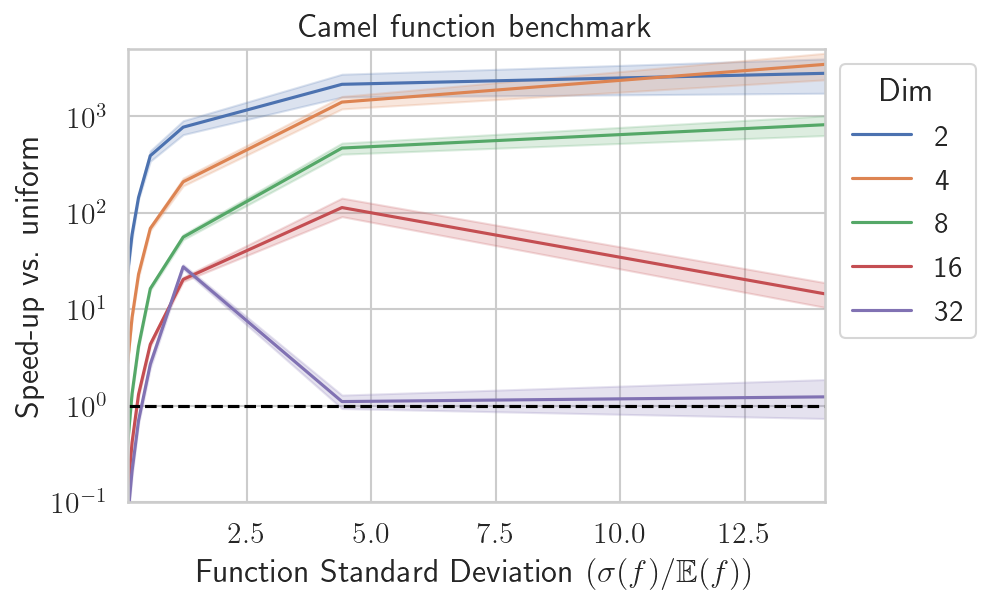

In [114]:
var_param = 'relative_std'
data = df[[var_param, 'flat_variance_ratio']].assign(Dim=df['d'].astype(str))
ax = sns.lineplot(data=data,x=var_param,y='flat_variance_ratio', hue='Dim')
ax.plot([data[var_param].min(),data[var_param].max()], [1.,1.],c='black',ls='--')
ax.set(yscale='log',ylim=[0.1, 5000], xlim=[data[var_param].min(),data[var_param].max()])
ax.set(xlabel='Function Standard Deviation $(\sigma(f)/\mathbb{E}(f))$', ylabel='Speed-up vs. uniform')
ax.legend(loc='upper left', bbox_to_anchor=(1, 1), title='Dim')
ax.set_title('Camel function benchmark')
plt.show()

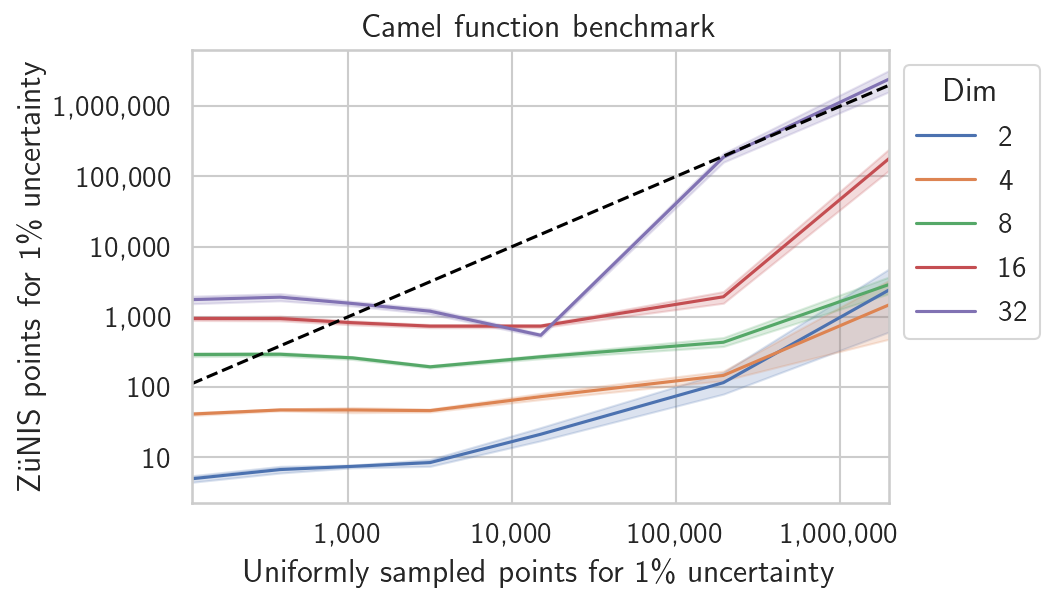

In [115]:
var_param='n_to_percent'
data = df[['flat_variance_ratio']].assign(Dim=df['d'].astype(str), n_to_percent=(df.relative_std*100)**2,
zunis_n_to_percent =  (df.relative_std*100)**2 / df.flat_variance_ratio)
ax = sns.lineplot(data=data,x=var_param,y='zunis_n_to_percent', hue='Dim')
ax.plot([data['n_to_percent'].min(),data['n_to_percent'].max()], [data['n_to_percent'].min(),data['n_to_percent'].max()],c='black',ls='--')
ax.set(yscale='log', xscale='log',xlim=[data['n_to_percent'].min(),data['n_to_percent'].max()])
ax.set(xlabel='Uniformly sampled points for 1\% uncertainty', ylabel='ZüNIS points for 1\% uncertainty')
ax.legend(loc='upper left', bbox_to_anchor=(1, 1), title='Dim')
ax.set_title('Camel function benchmark')
ax.get_xaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax.get_yaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
plt.show()

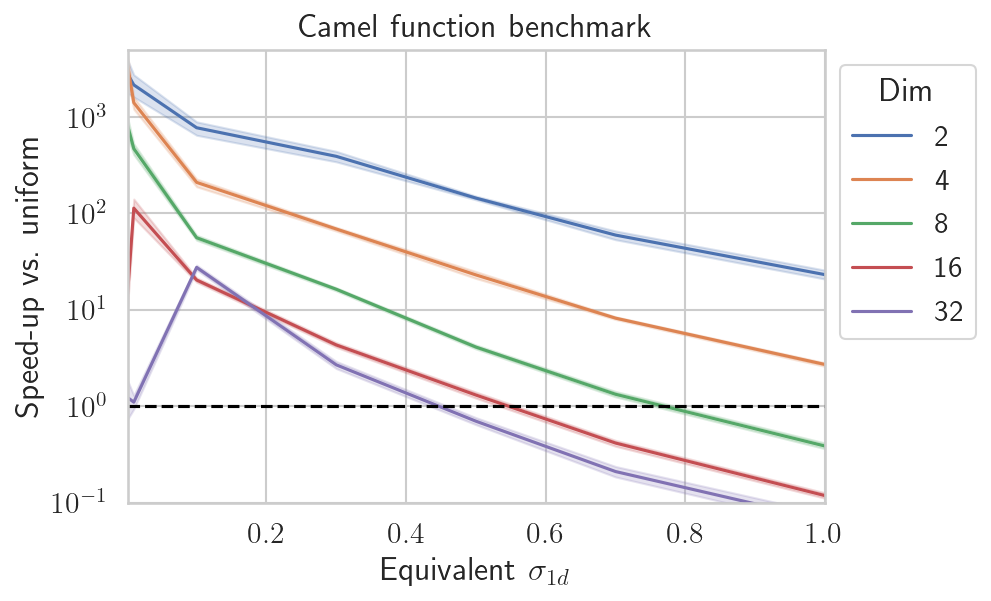

In [116]:
var_param = 'sigma_1d'
data = df[[var_param, 'flat_variance_ratio']].assign(Dim=df['d'].astype(str))
ax = sns.lineplot(data=data,x=var_param,y='flat_variance_ratio', hue='Dim')
ax.plot([data[var_param].min(),data[var_param].max()], [1.,1.],c='black',ls='--')
ax.set(yscale='log',ylim=[0.1, 5000], xlim=[data[var_param].min(),data[var_param].max()])
ax.set(xlabel='Equivalent $\sigma_{1d}$', ylabel='Speed-up vs. uniform')
ax.legend(loc='upper left', bbox_to_anchor=(1, 1), title='Dim')
ax.set_title('Camel function benchmark')
plt.show()

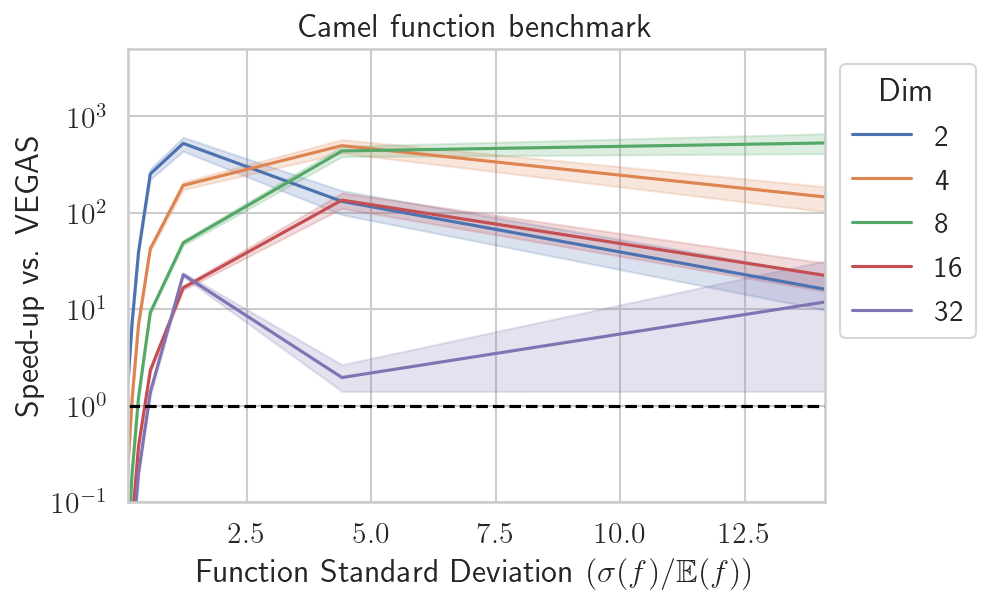

In [117]:
var_param = 'relative_std'
data = df[[var_param, 'vegas_variance_ratio']].assign(Dim=df['d'].astype(str))
ax = sns.lineplot(data=data,x=var_param,y='vegas_variance_ratio', hue='Dim')
ax.plot([data[var_param].min(),data[var_param].max()], [1.,1.],c='black',ls='--')
ax.set(yscale='log',ylim=[1.e-1, 5000], xlim=[data[var_param].min(),data[var_param].max()])
ax.set(xlabel='Function Standard Deviation $(\sigma(f)/\mathbb{E}(f))$', ylabel='Speed-up vs. VEGAS')
ax.legend(loc='upper left', bbox_to_anchor=(1, 1), title='Dim')
ax.set_title('Camel function benchmark')
plt.show()

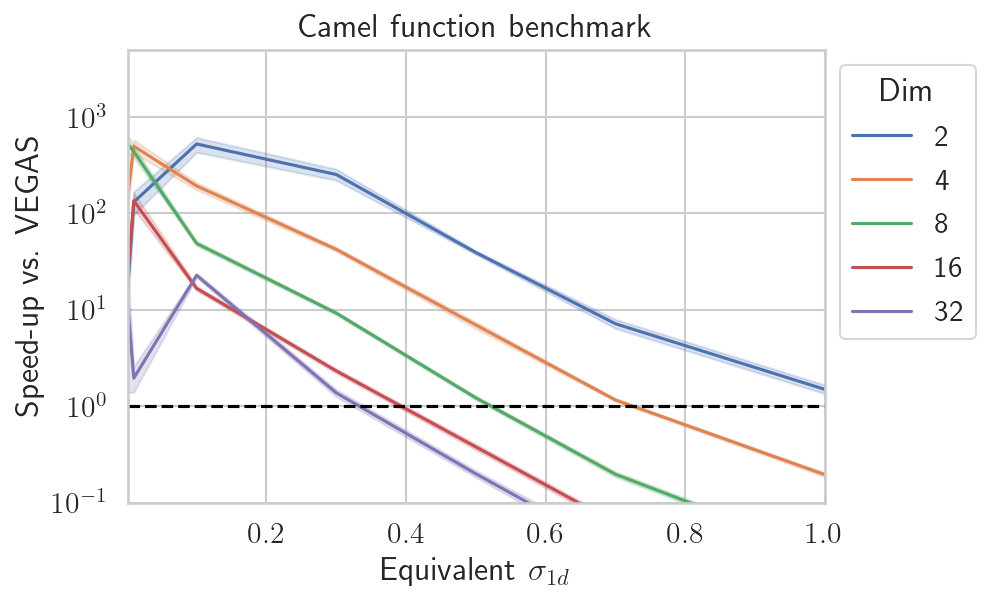

In [118]:
var_param = 'sigma_1d'
data = df[[var_param, 'vegas_variance_ratio']].assign(Dim=df['d'].astype(str))
ax = sns.lineplot(data=data,x=var_param,y='vegas_variance_ratio', hue='Dim')
ax.plot([data[var_param].min(),data[var_param].max()], [1.,1.],c='black',ls='--')
ax.set(yscale='log',ylim=[0.1, 5000], xlim=[data[var_param].min(),data[var_param].max()])
ax.set(xlabel='Equivalent $\sigma_{1d}$', ylabel='Speed-up vs. VEGAS')
ax.legend(loc='upper left', bbox_to_anchor=(1, 1), title='Dim')
ax.set_title('Camel function benchmark')
plt.show()

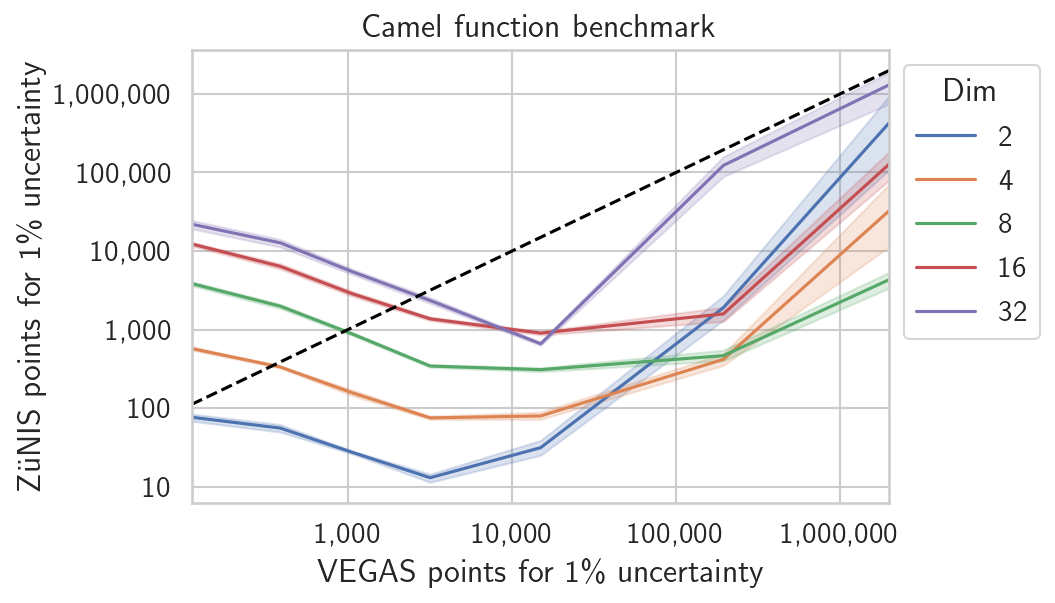

In [27]:
var_param='n_to_percent'
data = df[['vegas_variance_ratio']].assign(Dim=df['d'].astype(str), n_to_percent=(df.relative_std*100)**2,
zunis_n_to_percent =  (df.relative_std*100)**2 / df.vegas_variance_ratio)
ax = sns.lineplot(data=data,x=var_param,y='zunis_n_to_percent', hue='Dim')
ax.plot([data['n_to_percent'].min(),data['n_to_percent'].max()], [data['n_to_percent'].min(),data['n_to_percent'].max()],c='black',ls='--')
ax.set(yscale='log', xscale='log',xlim=[data['n_to_percent'].min(),data['n_to_percent'].max()])
ax.set(xlabel='VEGAS points for 1\% uncertainty', ylabel='ZüNIS points for 1\% uncertainty')
ax.legend(loc='upper left', bbox_to_anchor=(1, 1), title='Dim')
ax.set_title('Camel function benchmark')
ax.get_xaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax.get_yaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
plt.show()

### Making a table

In [137]:
import scikits.bootstrap as boot

In [197]:
table_vegas = df.groupby(['sigma_1d', 'd'])['vegas_variance_ratio'].agg(['mean',lambda x: tuple(boot.ci(x))])
table_flat = df.groupby(['sigma_1d', 'd'])['flat_variance_ratio'].agg(['mean',lambda x: tuple(boot.ci(x))])

table_std=df[['sigma_1d','d', 'relative_std']].drop_duplicates().set_index(['sigma_1d', 'd'])

table_vegas = table_vegas.join(table_std)
table_flat = table_flat.join(table_std)

In [265]:
table_string = ""
for tab in table_vegas.groupby(level=0):
    sig1d = tab[0]
    std = num2tex(f"{tab[1]['relative_std'].iloc[0]:.2f}")
    for r in tab[1].iterrows():
        row = r[1]
        mean_val, mean_exp = f"{row['mean']:.1e}".split('e')
        mean_exp = str(int(mean_exp))
        pretty_u = f"{(row['<lambda_0>'][1]-row['mean'])/ 10**(int(mean_exp)):.1f}"
        pretty_l = f"{(row['mean']-row['<lambda_0>'][0])/ 10**(int(mean_exp)):.1f}"
        table_string+=f" & ${mean_val}^{{+{pretty_u}}}_{{-{pretty_l}}} \\times 10^{{{mean_exp}}}$"
    table_string+=f" & ${sig1d}$  & ${std}$\\\ \n"
print(table_string)

 & $1.6^{+0.7}_{-0.6} \times 10^{1}$ & $1.5^{+0.4}_{-0.5} \times 10^{2}$ & $5.3^{+1.4}_{-1.1} \times 10^{2}$ & $2.2^{+0.8}_{-0.7} \times 10^{1}$ & $1.2^{+3.8}_{-1.0} \times 10^{1}$ & $0.001$  & $14.11$\\ 
 & $1.3^{+0.4}_{-0.3} \times 10^{2}$ & $5.0^{+0.7}_{-0.8} \times 10^{2}$ & $4.4^{+0.5}_{-0.6} \times 10^{2}$ & $1.4^{+0.3}_{-0.2} \times 10^{2}$ & $2.0^{+0.9}_{-0.5} \times 10^{0}$ & $0.01$  & $4.41$\\ 
 & $5.3^{+0.8}_{-1.0} \times 10^{2}$ & $1.9^{+0.1}_{-0.2} \times 10^{2}$ & $4.9^{+0.3}_{-0.3} \times 10^{1}$ & $1.7^{+0.1}_{-0.1} \times 10^{1}$ & $2.3^{+0.1}_{-0.1} \times 10^{1}$ & $0.1$  & $1.22$\\ 
 & $2.5^{+0.4}_{-0.3} \times 10^{2}$ & $4.2^{+0.2}_{-0.2} \times 10^{1}$ & $9.3^{+0.3}_{-0.4} \times 10^{0}$ & $2.3^{+0.1}_{-0.1} \times 10^{0}$ & $1.4^{+0.1}_{-0.1} \times 10^{0}$ & $0.3$  & $0.56$\\ 
 & $3.9^{+0.2}_{-0.2} \times 10^{1}$ & $7.0^{+0.6}_{-0.6} \times 10^{0}$ & $1.2^{+0.1}_{-0.1} \times 10^{0}$ & $3.8^{+0.3}_{-0.3} \times 10^{-1}$ & $2.0^{+0.2}_{-0.2} \times 10^{-1}$ & $0.

In [263]:
mean_val, mean_exp = f"{row['mean']:.2e}".split('e')
mean_exp = str(int(mean_exp))
pretty_u = f"{(row['<lambda_0>'][1]-row['mean'])/ 10**(int(mean_exp)):.2f}"
pretty_l = f"{(row['mean']-row['<lambda_0>'][0])/ 10**(int(mean_exp)):.2f}"

print(f"${mean_val}^{{+{pretty_u}}}_{{-{pretty_l}}} \\times 10^{{{mean_exp}}}$")

$5.30^{+1.21}_{-0.56} \times 10^{-3}$


# ROI

In [285]:
df_roi =  df.assign(roi_vegas = (df.vegas_variance_ratio) * (df.time_vegas / df.time_zunis))

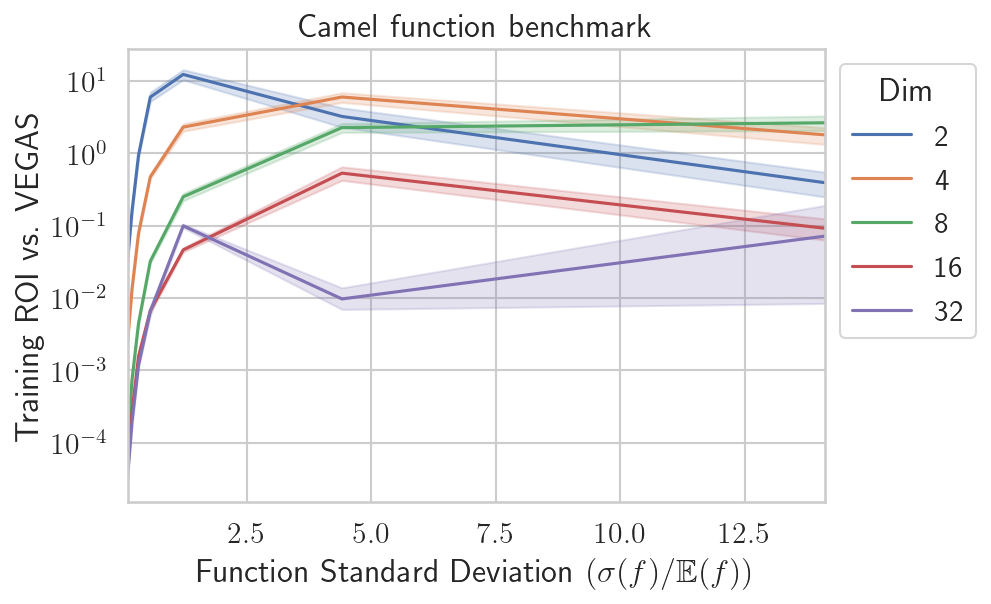

In [286]:
var_param = 'relative_std'
data = df_roi[[var_param, 'roi_vegas']].assign(Dim=df['d'].astype(str))
ax = sns.lineplot(data=data,x=var_param,y='roi_vegas', hue='Dim')
ax.set(yscale='log', xlim=[data[var_param].min(),data[var_param].max()])
ax.set(xlabel='Function Standard Deviation $(\sigma(f)/\mathbb{E}(f))$', ylabel='Training ROI vs. VEGAS')
ax.legend(loc='upper left', bbox_to_anchor=(1, 1), title='Dim')
ax.set_title('Camel function benchmark')
plt.show()

# Second search

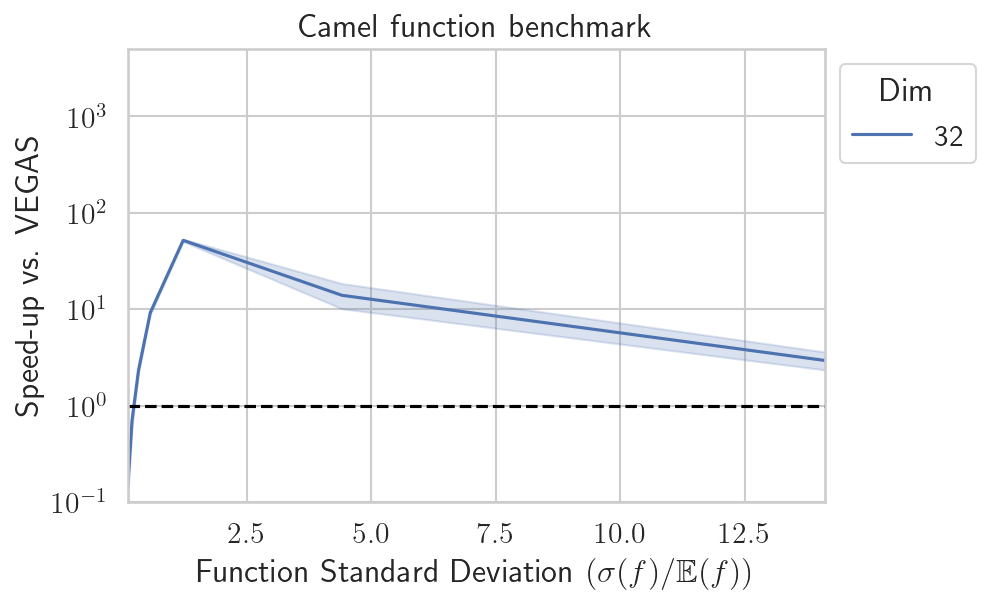

In [10]:
var_param = 'relative_std'
data = df2[[var_param, 'vegas_variance_ratio']].assign(Dim=df2['d'].astype(str))
ax = sns.lineplot(data=data,x=var_param,y='vegas_variance_ratio', hue='Dim')
ax.plot([data[var_param].min(),data[var_param].max()], [1.,1.],c='black',ls='--')
ax.set(yscale='log',ylim=[1.e-1, 5000], xlim=[data[var_param].min(),data[var_param].max()])
ax.set(xlabel='Function Standard Deviation $(\sigma(f)/\mathbb{E}(f))$', ylabel='Speed-up vs. VEGAS')
ax.legend(loc='upper left', bbox_to_anchor=(1, 1), title='Dim')
ax.set_title('Camel function benchmark')
plt.show()

In [28]:
df32 = df2.append(df.loc[(df.d==32) & (df.lr == 1.e-3)],ignore_index=True)

In [29]:
df32.n_points_survey.unique()

array([500000, 100000])

In [30]:
df32['Stats'] = df32.n_points_survey.apply(lambda x: {500000:"High", 100000:"Low"}[x])

In [55]:
df32.columns

Index(['value', 'value_std', 'value_history', 'target_history', 'flat_target',
       'flat_target_std', 'flat_sigma_cutoff', 'flat_sigmas_off',
       'flat_percent_difference', 'flat_variance_ratio', 'flat_match',
       'vegas_target', 'vegas_target_std', 'vegas_sigma_cutoff',
       'vegas_sigmas_off', 'vegas_percent_difference', 'vegas_variance_ratio',
       'vegas_match', 'exact_target', 'exact_target_std', 'exact_sigma_cutoff',
       'exact_sigmas_off', 'exact_percent_difference', 'exact_variance_ratio',
       'exact_match', 'flow', 'd_hidden', 'n_bins', 'n_hidden', 'masking',
       'repetitions', 'loss', 'n_points_survey', 'survey_strategy', 'n_iter',
       'minibatch_size', 'max_reloads', 'n_epochs', 'optim_cls', 'betas',
       'eps', 'lr', 'checkpoint', 'checkpoint_on_cuda', 'checkpoint_path',
       'n_iter_survey', 's', 'norm', 'd', 'time_zunis', 'time_vegas',
       'git_info', 'extra_data', 'sigma_1d', 'relative_std', 'Stats'],
      dtype='object')

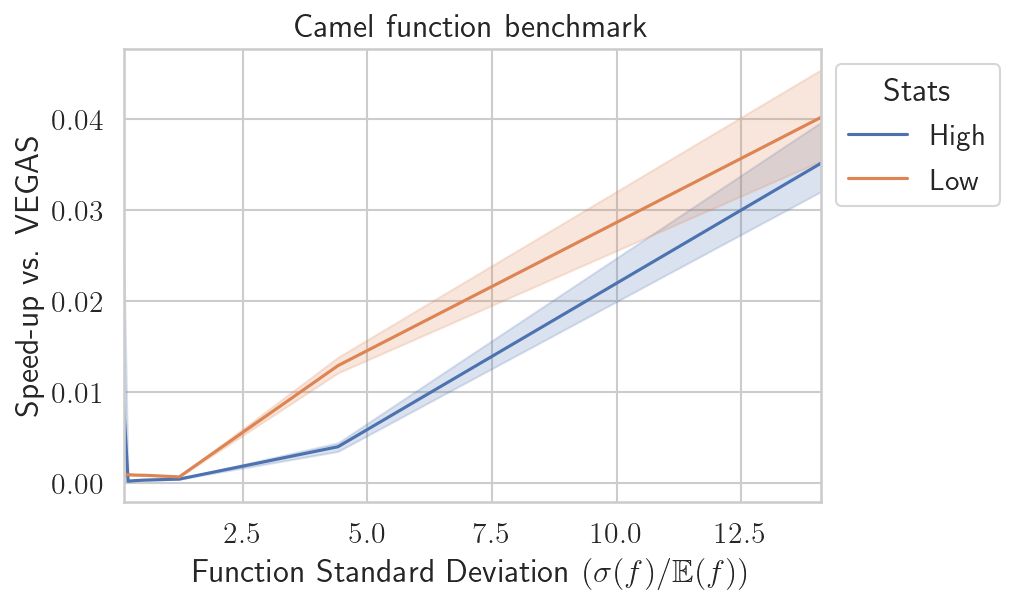

In [62]:
var_param = 'relative_std'
data = df32[[var_param,'Stats']].assign(learned_relative_std=df32['value_std']/df32['value'])
ax = sns.lineplot(data=data,x=var_param,y='learned_relative_std', hue='Stats')
ax.set(xlim=[data[var_param].min(),data[var_param].max()])
ax.set(xlabel='Function Standard Deviation $(\sigma(f)/\mathbb{E}(f))$', ylabel='Speed-up vs. VEGAS')
ax.legend(loc='upper left', bbox_to_anchor=(1, 1), title='Stats')
ax.set_title('Camel function benchmark')
plt.show()

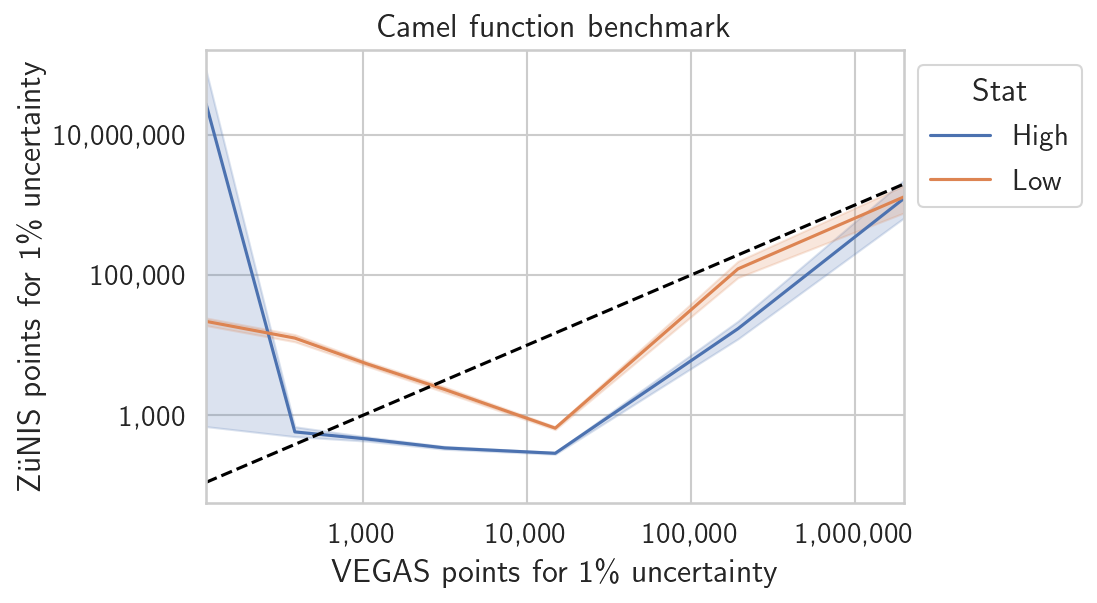

In [48]:
var_param='n_to_percent'
data = df32[['vegas_variance_ratio','Stats']].assign( n_to_percent=(df32.relative_std*100)**2,
zunis_n_to_percent =  (df32.relative_std*100)**2 / df32.vegas_variance_ratio)
ax = sns.lineplot(data=data,x=var_param,y='zunis_n_to_percent', hue='Stats')
ax.plot([data['n_to_percent'].min(),data['n_to_percent'].max()], [data['n_to_percent'].min(),data['n_to_percent'].max()],c='black',ls='--')
ax.set(yscale='log', xscale='log',xlim=[data['n_to_percent'].min(),data['n_to_percent'].max()])
ax.set(xlabel='VEGAS points for 1\% uncertainty', ylabel='ZüNIS points for 1\% uncertainty')
ax.legend(loc='upper left', bbox_to_anchor=(1, 1), title='Stat')
ax.set_title('Camel function benchmark')
ax.get_xaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax.get_yaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
plt.show()

In [49]:
df2['d'] = "32 - high stat"

In [54]:
df2.loc[df2.sigma_1d == 1.].vegas_variance_ratio

69    1.506621e-01
70    4.008822e-07
71    1.561316e-01
72    1.730018e-01
73    1.650994e-01
74    1.737272e-01
75    1.536022e-01
76    1.315160e-01
77    5.844686e-02
78    1.632734e-01
Name: vegas_variance_ratio, dtype: float64

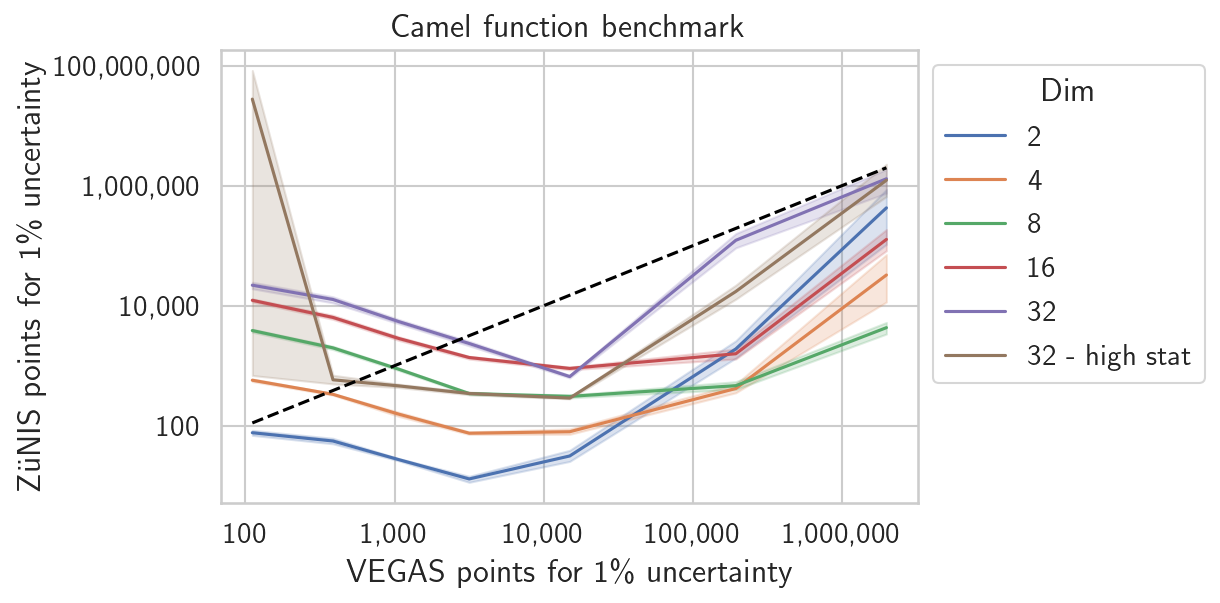

In [50]:
var_param='n_to_percent'
dfcheat= df.append(df2,ignore_index=True)
data = dfcheat[['vegas_variance_ratio']].assign(Dim=dfcheat['d'].astype(str), n_to_percent=(dfcheat.relative_std*100)**2,
zunis_n_to_percent =  (dfcheat.relative_std*100)**2 / dfcheat.vegas_variance_ratio)
ax = sns.lineplot(data=data,x=var_param,y='zunis_n_to_percent', hue='Dim')
ax.plot([data['n_to_percent'].min(),data['n_to_percent'].max()], [data['n_to_percent'].min(),data['n_to_percent'].max()],c='black',ls='--')
ax.set(yscale='log', xscale='log')
ax.set(xlabel='VEGAS points for 1\% uncertainty', ylabel='ZüNIS points for 1\% uncertainty')
ax.legend(loc='upper left', bbox_to_anchor=(1, 1), title='Dim')
ax.set_title('Camel function benchmark')
ax.get_xaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax.get_yaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
plt.show()

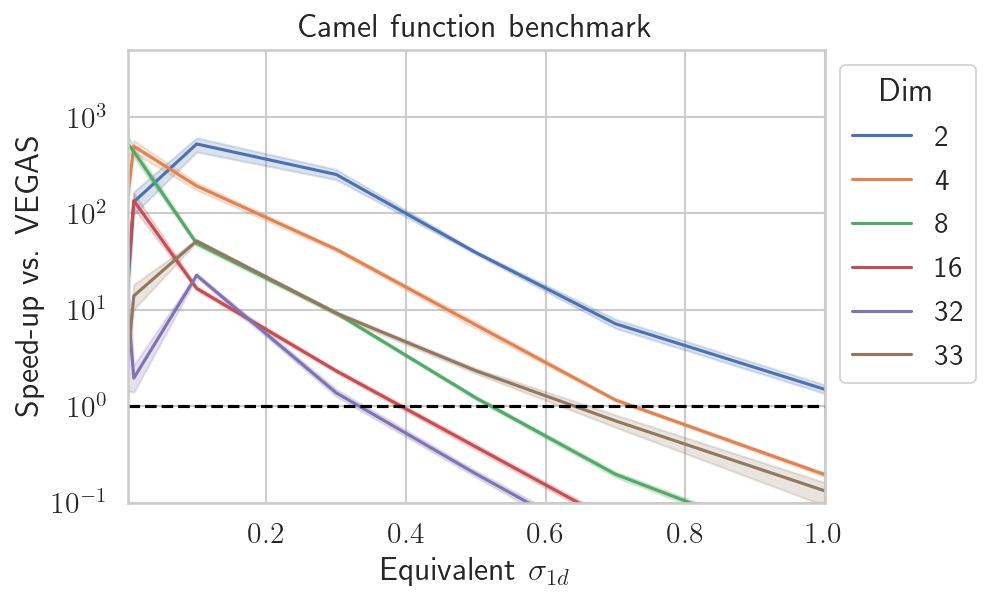

In [45]:
var_param = 'sigma_1d'
data = dfcheat[[var_param, 'vegas_variance_ratio']].assign(Dim=dfcheat['d'].astype(str))
ax = sns.lineplot(data=data,x=var_param,y='vegas_variance_ratio', hue='Dim')
ax.plot([data[var_param].min(),data[var_param].max()], [1.,1.],c='black',ls='--')
ax.set(yscale='log',ylim=[0.1, 5000], xlim=[data[var_param].min(),data[var_param].max()])
ax.set(xlabel='Equivalent $\sigma_{1d}$', ylabel='Speed-up vs. VEGAS')
ax.legend(loc='upper left', bbox_to_anchor=(1, 1), title='Dim')
ax.set_title('Camel function benchmark')
plt.show()

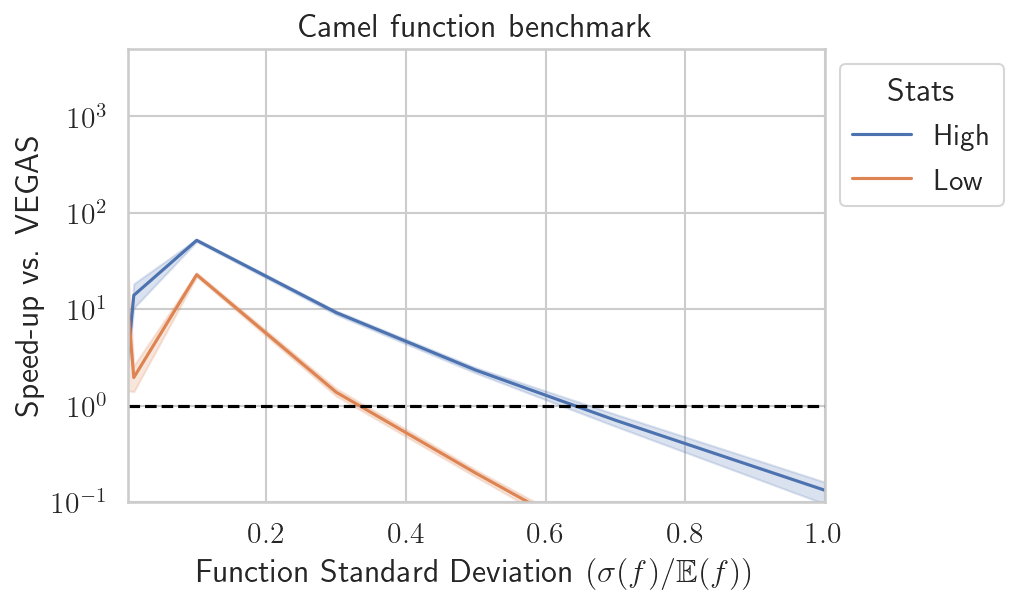

In [47]:
var_param = 'sigma_1d'
data = df32[[var_param, 'vegas_variance_ratio','Stats']]
ax = sns.lineplot(data=data,x=var_param,y='vegas_variance_ratio', hue='Stats')
ax.plot([data[var_param].min(),data[var_param].max()], [1.,1.],c='black',ls='--')
ax.set(yscale='log',ylim=[1.e-1, 5000], xlim=[data[var_param].min(),data[var_param].max()])
ax.set(xlabel='Function Standard Deviation $(\sigma(f)/\mathbb{E}(f))$', ylabel='Speed-up vs. VEGAS')
ax.legend(loc='upper left', bbox_to_anchor=(1, 1), title='Stats')
ax.set_title('Camel function benchmark')
plt.show()

In [65]:
from itertools import combinations

In [102]:
multiplexed = df32.loc[df32.Stats=='High'].merge(df32.loc[df32.Stats=='Low'], on='sigma_1d', how='inner')

In [ ]:
multiplexed.ve

In [143]:
multiplexed["ratio"] = (multiplexed.value_std_y / multiplexed.value_std_x)**2

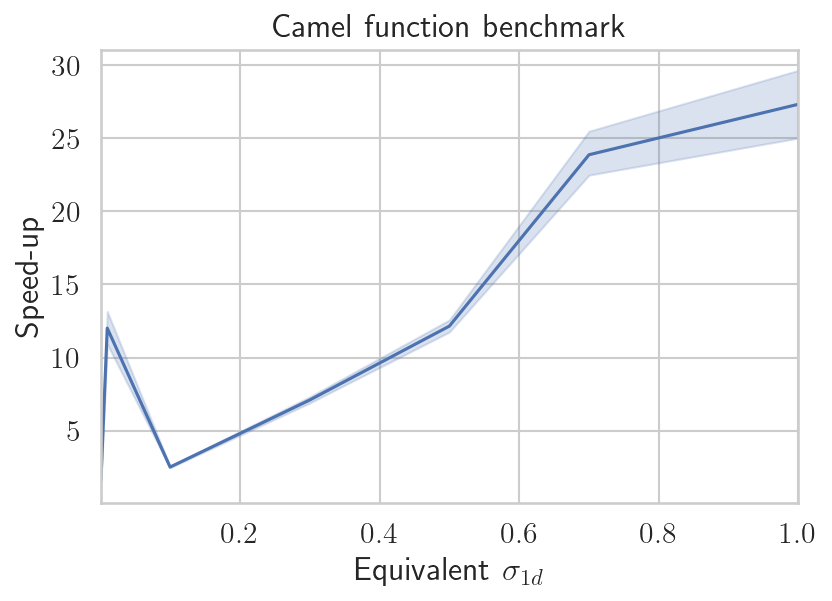

In [146]:
var_param = 'sigma_1d'
data = multiplexed[[var_param, 'ratio']]
ax = sns.lineplot(data=data,x=var_param,y='ratio')
ax.set(xlim=[data[var_param].min(),data[var_param].max()])
ax.set(xlabel='Equivalent $\sigma_{1d}$', ylabel='Speed-up')
# ax.set(yscale='log')
ax.set_title('Camel function benchmark')
plt.show()